In [1]:
import pandas as pd
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split
import csv
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np
import torch.nn.functional as F

from gensim.utils import simple_preprocess


import transformers
from transformers import  AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                             title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rahulvyasm/netflix-movies-and-tv-shows                          Netflix Movies and TV Shows                         1MB  2024-04-10 09:48:38          12365        260  1.0              
sahirmaharajj/school-student-daily-attendance                   School Student Daily Attendance                     2MB  2024-04-29 19:29:56           1413         33  1.0              
jaidalmotra/pokemon-dataset                                     Pokemon Dataset                                    19KB  2024-04-30 10:38:36           1015         35  1.0              
anandshaw2001/airlines-booking-csv                              Airlin

In [4]:
!kaggle competitions download -c nlp-getting-started

100% 593k/593k [00:00<00:00, 1.39MB/s]
100% 593k/593k [00:00<00:00, 1.39MB/s]


In [5]:
! unzip nlp-getting-started.zip -d nlp-getting-started

Archive:  nlp-getting-started.zip
  inflating: nlp-getting-started/sample_submission.csv  
  inflating: nlp-getting-started/test.csv  
  inflating: nlp-getting-started/train.csv  


In [6]:
df = pd.read_csv("nlp-getting-started/train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


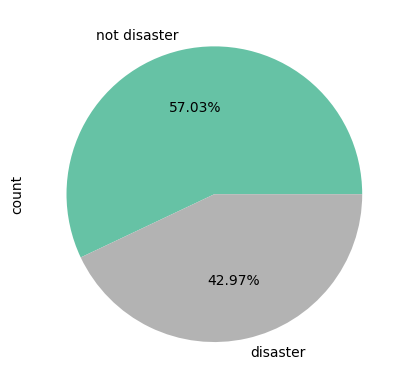

In [7]:
import matplotlib.pyplot as plt # plotting
import seaborn as sns  # advance plotting

df['target'].value_counts().plot(kind='pie',autopct='%.2f%%',labels=['not disaster','disaster'],cmap='Set2')
# distribution of Toxic or Non Toxic. 1 detemines Toxic
plt.show()


In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
class MyDataset(Dataset):

    def __init__(self, data_dir, max_length = 45, transform=None, target_transform=None):
        super(MyDataset, self).__init__()

        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform
        self.max_length = max_length
        texts, labels = [], []
        with open(data_dir) as csv_file:
            reader = csv.reader(csv_file, quotechar='"')
            for idx, line in enumerate(reader):
                if idx == 0:
                    continue
                text = line[3]
                text = ' '.join(simple_preprocess(text))

                label = int(line[4])

                labels.append(label)
                texts.append(text)

        self.label_list = labels
        self.text_list = texts

    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, index):
        label = self.label_list[index]
        if self.target_transform:
            label = self.target_transform(label)
        text = self.text_list[index]
        encoding = tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': label
        }

test = MyDataset(data_dir="nlp-getting-started/train.csv",target_transform=lambda x: F.one_hot(torch.tensor(x), num_classes=2).to(torch.float))
print (test.__getitem__(index=0))

{'text': 'our deeds are the reason of this earthquake may allah forgive us all', 'input_ids': tensor([  101,  2256, 15616,  2024,  1996,  3114,  1997,  2023,  8372,  2089,
        16455,  9641,  2149,  2035,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]), 'attention_masks': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'targets': tensor([0., 1.])}


In [10]:
from torchtext.functional import to_tensor
from torchvision.transforms import ToTensor, Lambda

n_classes = 2
batch_size = 32
dataset = MyDataset(data_dir="nlp-getting-started/train.csv",target_transform=lambda x: F.one_hot(torch.tensor(x), num_classes=2).to(torch.float))

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
#val_size = int(0.2 * len(dataset))
val_size = len(dataset)  - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


6,090 training samples
1,523 validation samples


In [11]:
for batch in train_dataset:
  print(batch)
  break

{'text': 'the far right racist avigdorliberman calls for destruction of susiya previously he also called for beheadings http co li otxt hh', 'input_ids': tensor([  101,  1996,  2521,  2157, 16939, 20704,  8004,  7983, 29521, 18689,
         4455,  2005,  6215,  1997, 10514,  5332,  3148,  3130,  2002,  2036,
         2170,  2005,  2022,  4974,  8613,  8299,  2522,  5622, 27178, 18413,
         1044,  2232,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]), 'attention_masks': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'targets': tensor([0., 1.])}


In [12]:
from transformers import BertPreTrainedModel, BertModel
import torch.nn as nn

class TextClassifier(BertPreTrainedModel):
    def __init__(self, config, num_labels= 2, dropout_rate= 0.15 ):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = outputs.pooler_output
        output = self.dropout(output)
        output = self.linear(output)
        output = F.softmax(output, dim=1)
        return output

In [13]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [14]:
import time
from tqdm import tqdm

def train(model, loss_fn, optimizer, train_loader, epoch):
    model.zero_grad()
    model.train()
    epoch_loss = 0 # loss per epoch
    losses = []
    epoch_acc = 0 # accuracy per epoch

    for data in tqdm(train_loader, f'Epoch: {epoch}'):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()

        predictions = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )



        pred = torch.zeros_like(predictions)
        pred[torch.arange(len(predictions)), torch.argmax(predictions, dim=1)] = 1
        correct_preds = (pred * targets).float()
        accuracy = correct_preds.sum()/len(correct_preds)

        loss = loss_fn(predictions, targets)

        #epoch_loss += loss.item()  # add the loss for this batch to calculate the loss for whole epoch
        epoch_acc += accuracy.item() # .item() tend to give the exact number from the tensor of shape [1,]
        losses.append(loss.item())
        loss.backward()

        optimizer.step()

    print(f'Train Accuracy: {epoch_acc/len(train_loader)} Loss: {np.mean(losses)}')


    return epoch_acc/len(train_loader), np.mean(losses)

def test(model, loss_fn, test_loader):
    model.eval()
    losses = []
    epoch_acc = 0

    with torch.no_grad():
        for data in test_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            predictions = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            pred = torch.zeros_like(predictions)
            pred[torch.arange(len(predictions)), torch.argmax(predictions, dim=1)] = 1
            correct_preds = (pred * targets).float()
            accuracy = correct_preds.sum()/len(correct_preds)

            loss = loss_fn(predictions, targets)

            epoch_acc += accuracy.item()
            losses.append(loss.item())
            time.sleep(0.001)

    print(f'Test Accuracy: {epoch_acc/len(test_loader)} Loss: {np.mean(losses)}')
    return epoch_acc/len(test_loader)

In [19]:
config = BertConfig.from_pretrained('bert-base-uncased')
model = TextClassifier(config)


lr = 1e-5
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()
model.to(device)

n_epoches = 30

for epoch in range(n_epoches):
    print()
    train(model, loss_fn, optimizer, train_dataloader, epoch+1)
    test(model, loss_fn, val_dataloader)


torch.save(model.state_dict(), 'model.pth')

Epoch: 1: 100%|██████████| 191/191 [00:15<00:00, 12.23it/s]


Train Accuracy: 0.5783049738844027 Loss: 0.6754446469676432
Test Accuracy: 0.6373355264465014 Loss: 0.6435943506658077



Epoch: 2: 100%|██████████| 191/191 [00:15<00:00, 12.24it/s]


Train Accuracy: 0.6910667539579082 Loss: 0.6021029507614555
Test Accuracy: 0.6185923796147108 Loss: 0.6693215233584245



Epoch: 3: 100%|██████████| 191/191 [00:15<00:00, 12.25it/s]


Train Accuracy: 0.7607657069935224 Loss: 0.5409389809164077
Test Accuracy: 0.7384525773425897 Loss: 0.5649561720589796



Epoch: 4: 100%|██████████| 191/191 [00:15<00:00, 12.23it/s]


Train Accuracy: 0.8137434555597954 Loss: 0.49345311319640794
Test Accuracy: 0.7575383769969145 Loss: 0.5471454070260128



Epoch: 5: 100%|██████████| 191/191 [00:15<00:00, 12.27it/s]


Train Accuracy: 0.832918848354779 Loss: 0.4747717419531957
Test Accuracy: 0.7629523028930029 Loss: 0.53306761632363



Epoch: 6: 100%|██████████| 191/191 [00:15<00:00, 12.23it/s]


Train Accuracy: 0.8494437174647266 Loss: 0.45894386740255105
Test Accuracy: 0.771004660675923 Loss: 0.5343938507139683



Epoch: 7: 100%|██████████| 191/191 [00:15<00:00, 12.25it/s]


Train Accuracy: 0.8666557591623036 Loss: 0.44389314582834694
Test Accuracy: 0.7525356362263361 Loss: 0.553463464602828



Epoch: 8: 100%|██████████| 191/191 [00:15<00:00, 12.24it/s]


Train Accuracy: 0.8784358638743456 Loss: 0.43190214615217676
Test Accuracy: 0.7597313597798347 Loss: 0.5429362238695224



Epoch: 9: 100%|██████████| 191/191 [00:15<00:00, 12.25it/s]


Train Accuracy: 0.8792212043757214 Loss: 0.4320380297630869
Test Accuracy: 0.777549342562755 Loss: 0.5298599724968275



Epoch: 10: 100%|██████████| 191/191 [00:15<00:00, 12.23it/s]


Train Accuracy: 0.8853075916230366 Loss: 0.42636128760757247
Test Accuracy: 0.7820723690092564 Loss: 0.527950581163168



Epoch: 11: 100%|██████████| 191/191 [00:15<00:00, 12.25it/s]


Train Accuracy: 0.8911649216532083 Loss: 0.4196352013118604
Test Accuracy: 0.7850877195596695 Loss: 0.5231110043823719



Epoch: 12: 100%|██████████| 191/191 [00:15<00:00, 12.23it/s]


Train Accuracy: 0.8957133508477536 Loss: 0.41559470339595334
Test Accuracy: 0.7484237936635812 Loss: 0.5577312757571539



Epoch: 13: 100%|██████████| 191/191 [00:15<00:00, 12.25it/s]


Train Accuracy: 0.876767015894046 Loss: 0.43514900166950926
Test Accuracy: 0.7766241778930029 Loss: 0.5309113680074612



Epoch: 14: 100%|██████████| 191/191 [00:15<00:00, 12.25it/s]


Train Accuracy: 0.9116164923338366 Loss: 0.4006359879883172
Test Accuracy: 0.7631578942139944 Loss: 0.5463428938140472



Epoch: 15: 100%|██████████| 191/191 [00:15<00:00, 12.24it/s]


Train Accuracy: 0.9047774869109948 Loss: 0.40710128789172745
Test Accuracy: 0.7714501097798347 Loss: 0.5354845188558102



Epoch: 16: 100%|██████████| 191/191 [00:15<00:00, 12.24it/s]


Train Accuracy: 0.9100130890052356 Loss: 0.40242233966033497
Test Accuracy: 0.7803248353302479 Loss: 0.5245405348638693



Epoch: 17: 100%|██████████| 191/191 [00:15<00:00, 12.26it/s]


Train Accuracy: 0.9170484293193717 Loss: 0.39420040053222816
Test Accuracy: 0.7772752195596695 Loss: 0.5281085384388765



Epoch: 18: 100%|██████████| 191/191 [00:15<00:00, 12.25it/s]


Train Accuracy: 0.9248691101348837 Loss: 0.3883643897728146
Test Accuracy: 0.769051535675923 Loss: 0.5410607798645893



Epoch: 19: 100%|██████████| 191/191 [00:15<00:00, 12.23it/s]


Train Accuracy: 0.9239201570680629 Loss: 0.388743621204536
Test Accuracy: 0.7796737936635812 Loss: 0.5262465265889963



Epoch: 20: 100%|██████████| 191/191 [00:15<00:00, 12.26it/s]


Train Accuracy: 0.9243455498006331 Loss: 0.3880221305405282
Test Accuracy: 0.7734032347798347 Loss: 0.5354877884189287



Epoch: 21: 100%|██████████| 191/191 [00:15<00:00, 12.24it/s]


Train Accuracy: 0.9191426703443077 Loss: 0.3938260605822059
Test Accuracy: 0.7847108008960882 Loss: 0.5192855515827736



Epoch: 22: 100%|██████████| 191/191 [00:15<00:00, 12.24it/s]


Train Accuracy: 0.9268651832460733 Loss: 0.38493233607077476
Test Accuracy: 0.7777206686635812 Loss: 0.5293218574176232



Epoch: 23: 100%|██████████| 191/191 [00:15<00:00, 12.23it/s]


Train Accuracy: 0.931773560209424 Loss: 0.38109914030080067
Test Accuracy: 0.7764185853302479 Loss: 0.5329183662931124



Epoch: 24: 100%|██████████| 191/191 [00:15<00:00, 12.25it/s]


Train Accuracy: 0.9294502619673445 Loss: 0.3830368784085618
Test Accuracy: 0.7711759867767493 Loss: 0.539263409251968



Epoch: 25: 100%|██████████| 191/191 [00:15<00:00, 12.24it/s]


Train Accuracy: 0.9250327227003288 Loss: 0.38657074324123525
Test Accuracy: 0.7755619523425897 Loss: 0.530709117030104



Epoch: 26: 100%|██████████| 191/191 [00:15<00:00, 12.22it/s]


Train Accuracy: 0.9361910994764397 Loss: 0.37640625768931124
Test Accuracy: 0.7868352519969145 Loss: 0.5235646596799294



Epoch: 27: 100%|██████████| 191/191 [00:15<00:00, 12.23it/s]


Train Accuracy: 0.9352094240837696 Loss: 0.37786068217292507
Test Accuracy: 0.791221217562755 Loss: 0.5188544616103172



Epoch: 28: 100%|██████████| 191/191 [00:15<00:00, 12.25it/s]


Train Accuracy: 0.9409358638743456 Loss: 0.37137155851144443
Test Accuracy: 0.7833744523425897 Loss: 0.5248411732415358



Epoch: 29: 100%|██████████| 191/191 [00:15<00:00, 12.27it/s]


Train Accuracy: 0.9407722513089005 Loss: 0.37193747527936366
Test Accuracy: 0.765145285675923 Loss: 0.5417407937347889



Epoch: 30: 100%|██████████| 191/191 [00:15<00:00, 12.25it/s]


Train Accuracy: 0.9300719895912091 Loss: 0.3826611308839309
Test Accuracy: 0.7903303181131681 Loss: 0.517873485883077


In [17]:
config = BertConfig.from_pretrained('bert-base-uncased')
model = TextClassifier(config)
model.load_state_dict(torch.load('model.pth'))
model.eval()

TextClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af